<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#BRIEF--descriptor" data-toc-modified-id="BRIEF--descriptor-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>BRIEF  descriptor</a></span></li><li><span><a href="#Loading-a-database" data-toc-modified-id="Loading-a-database-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Loading a database</a></span></li><li><span><a href="#Building-vocabulary" data-toc-modified-id="Building-vocabulary-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Building vocabulary</a></span></li><li><span><a href="#Searching-given-a-query" data-toc-modified-id="Searching-given-a-query-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Searching given a query</a></span></li><li><span><a href="#We-can-put-more-weight-on-the-features-that-are-activated-by-our-query-when-we-do-search." data-toc-modified-id="We-can-put-more-weight-on-the-features-that-are-activated-by-our-query-when-we-do-search.-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>We can put more weight on the features that are activated by our query when we do search.</a></span></li><li><span><a href="#Let-us-add-jina-images" data-toc-modified-id="Let-us-add-jina-images-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Let us add jina images</a></span></li></ul></div>

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

(480, 640, 3)


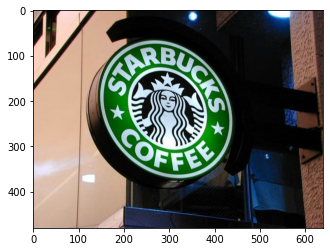

In [2]:
img = cv.imread('../data/starbucks_logo.jpg')
print(img.shape)
plt.imshow(img)

## BRIEF  descriptor

In [75]:
query = cv.imread('../data/starbucks_logo.jpg')


# Initiate BRIEF extractor
brief = cv.xfeatures2d.BriefDescriptorExtractor_create()
star = cv.xfeatures2d.StarDetector_create()
kp = star.detect(query,None)
kp, des = brief.compute(query, kp)

In [76]:
kp, des = brief.compute(query, kp)
des.shape

(468, 32)

In [77]:
des.shape

(468, 32)

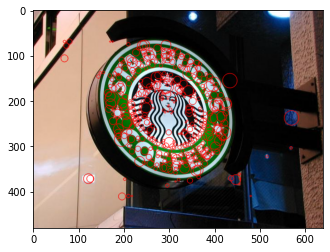

(<matplotlib.image.AxesImage at 0x7fefd91324f0>, None)

In [78]:
img2 = cv.drawKeypoints(query,kp,None,(255,0,0),4)
plt.imshow(img2),plt.show()

In [79]:
keypoint = kp[1]

print(keypoint.angle )
print(keypoint.class_id)
print(keypoint.convert)
print(keypoint.octave)
print(keypoint.overlap)
print(keypoint.pt)
print(keypoint.response)
print(keypoint.size)

-1.0
-1
<built-in method convert of type object at 0x12434d070>
0
<built-in method overlap of type object at 0x12434d070>
(80.0, 69.0)
30.0
12.0


## Loading a database

In [80]:
import glob

starbucks_images = glob.glob('../data/starbucks_images/*')
cafe_images = glob.glob('../data/cafe_images/*')
scuptures_images = glob.glob('../data/sculptures_images/*')


images = []
for im_path in starbucks_images:
    img = cv.imread(im_path)
    images.append(img)

for im_path in cafe_images:
    img = cv.imread(im_path)
    images.append(img)

for im_path in scuptures_images:
    img = cv.imread(im_path)
    images.append(img)

print(len(images))

39


## Building vocabulary


A Vocabulary for a Bag of words descriptor can be implemented as follows


https://datascience.stackexchange.com/questions/24002/how-do-i-represent-surf-features-into-bag-of-words-to-determine-nearest-neighbor

In [118]:
descriptors = []
for image in images:
    brief = cv.xfeatures2d.BriefDescriptorExtractor_create()
    star = cv.xfeatures2d.StarDetector_create()
    kp = star.detect(image, None)
    kp, des = brief.compute(image, kp)
    if isinstance(des, np.ndarray):
        descriptors.append(des)

In [119]:
X_tr_descriptors = np.vstack(descriptors)
X_tr_descriptors.shape

(16583, 32)

In [120]:
import sklearn
from sklearn import cluster
kmeans = sklearn.cluster.KMeans(n_clusters=512)
kmeans.fit(X_tr_descriptors)

KMeans(n_clusters=512)

In [121]:
kmeans.cluster_centers_.shape

(512, 32)

We could compute for each vector in  `des` the distance between that vector and all codewords as follows:

```
# distance between one descriptor and all the descriptors in the codebook
np.linalg.norm(des[0] - kmeans.cluster_centers_,axis=1)[0]
```

Nevertheless we can do it in a batched approach using `pairwise_distances`

In [122]:
print('des.shape =', des.shape)
print('kmeans.cluster_centers_.shape =', kmeans.cluster_centers_.shape)
distances = sklearn.metrics.pairwise_distances(des,  kmeans.cluster_centers_)
distances.shape

des.shape = (115, 32)
kmeans.cluster_centers_.shape = (512, 32)


(115, 512)

Now we can count for each keypoint descriptor in an image how many matches across each codeword we have and build a vector of the counts

In [123]:
#min_dist_param = des.mean()
#descriptor_to_codebook_matches = np.sum(distances < min_dist_param, axis=0)
#descriptor_to_codebook_matches.shape

In [134]:
np.argmin(distances,axis=0).shape
#descriptor_to_codebook_matches = 

(512,)

In [145]:
def build_bog_vector(distances, n_bog):
    result = np.zeros(n_bog)

    for i,row in enumerate(distances):
        result[np.argmin(row)] += 1

    return result

In [146]:
build_bog_vector(distances, n_bog=kmeans.n_clusters)

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 4., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 2., 0., 0., 0.,
       1., 0., 1., 0., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

Now we can put this process inside a function that given an image and a kmeans containing a codebook computes the matches between descriptors of the image and codevectors

In [147]:
def descriptors_image(image, kmeans, min_dist_param):
    n_features = kmeans.cluster_centers_.shape[1]
    
    brief = cv.xfeatures2d.BriefDescriptorExtractor_create()
    star = cv.xfeatures2d.StarDetector_create()
    kp = star.detect(image, None)
    kp, des = brief.compute(image, kp)

    if not isinstance(des, np.ndarray):
        des = np.zeros((1,n_features))
    
    distances = sklearn.metrics.pairwise_distances(des,  kmeans.cluster_centers_)
    
    descriptor_codebook_matches = build_bog_vector(distances, n_bog=kmeans.n_clusters)
    return descriptor_codebook_matches

In [149]:
image_descriptors = []

for k,image in enumerate(images):
    image_descriptor =  descriptors_image(image, kmeans, min_dist_param)
    image_descriptors.append(image_descriptor)
    
X_embeddings = np.array(image_descriptors)

True

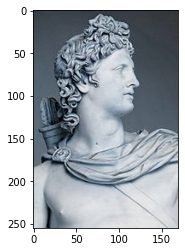

In [153]:
# No descriptor is produced for this image
image = images[27]
plt.imshow(image)

brief = cv.xfeatures2d.BriefDescriptorExtractor_create()
star = cv.xfeatures2d.StarDetector_create()
kp = star.detect(image, None)
kp, des = brief.compute(image, kp)

des ==None

## Searching given a query (bad results if done naively)


query image:


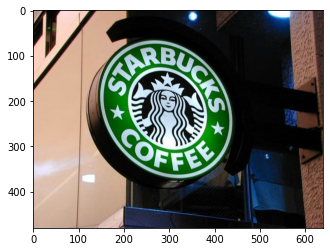

In [159]:
print('\nquery image:')
plt.imshow(query)

First we need to compute the embedding of the query and the distance between the embedding and each of the embeddings stored in our database

In [249]:
query_embedding = descriptors_image(query, kmeans, min_dist_param)
#query_embedding += + (query_embedding<2)
distances_to_query = np.linalg.norm(query_embedding - X_embeddings,axis=1)
closest_indices = distances_to_query.argsort()
closest_distances = [distances_to_query[k] for k in closest_indices] 
len(closest_indices)

39

Note that this is not working because we put all features equally relevant.
Shoudn´t we focus on the keypoints that are activated by the query? That´s the idea behind putting more weight into some features (next cells)

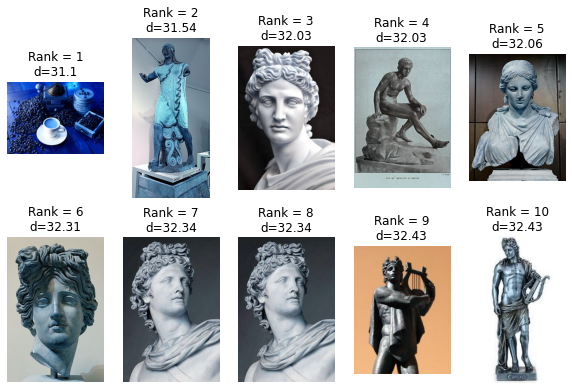

In [162]:
plt.figure(figsize=(10,10))
columns = 5
top_k = 10

closest_k_inds = closest_indices[0:top_k]
closest_k_dists = closest_distances[0:top_k]


for i, (ind, dist) in enumerate(zip(closest_k_inds, closest_k_dists)):
    fig = plt.subplot( int(len(closest_k_dists) / columns + 1), columns, i + 1)
    plt.axis('off')
    fig.set_title(f"Rank = {i+1}\nd={round(dist,2)}")
    plt.imshow(images[ind])
    

## We can put more weight on the features that are activated by our query when we do search.

We can do this in two diferent ways.

- we can find the codevectors that are more active in a feature descriptor and 'incresase their value'.
    - This can be done finding the features that are more active and updating their value `query_embedding[query_embedding >=2]  = delta* query_embedding[query_embedding >=2]`.
    
- We could instead use a weighted distance where weights are adapted to provide more importance to the features that are more activated in the query.


query image:


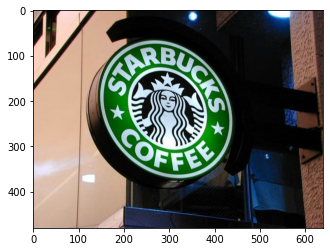

In [166]:
print('\nquery image:')
plt.imshow(query)

In [173]:
query_embedding = descriptors_image(query, kmeans, min_dist_param)
query_embedding[query_embedding >=2]  = 10*query_embedding[query_embedding >=2] 

distances_to_query = np.linalg.norm(query_embedding - X_embeddings,axis=1)
closest_indices = distances_to_query.argsort()
closest_distances = [distances_to_query[k] for k in closest_indices] 
len(closest_indices)

39

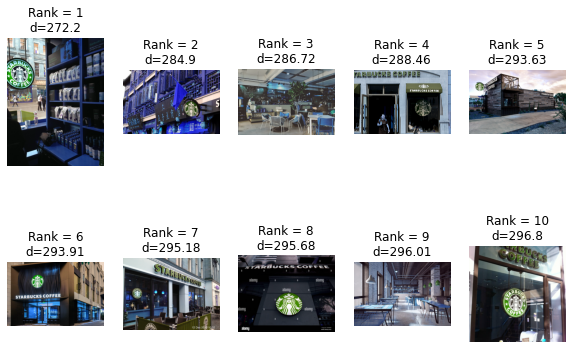

In [174]:
plt.figure(figsize=(10,10))
columns = 5
top_k = 10

closest_k_inds = closest_indices[0:top_k]
closest_k_dists = closest_distances[0:top_k]

for i, (ind, dist) in enumerate(zip(closest_k_inds, closest_k_dists)):
    fig = plt.subplot(int(len(closest_k_dists) / columns + 1), columns, i + 1)
    plt.axis('off')
    fig.set_title(f"Rank = {i+1}\nd={round(dist,2)}")
    plt.imshow(images[ind])

## Let us add jina images

In [175]:
jina_images = glob.glob('../data/jina_images/*')

images_new = []
for im_path in jina_images:
    img = cv.imread(im_path)
    images_new.append(img)


query image:


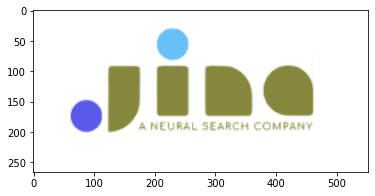

In [176]:
print('\nquery image:')
query = images_new[5]
plt.imshow(query)

In [177]:
images += images_new

In [236]:
len(images)

45

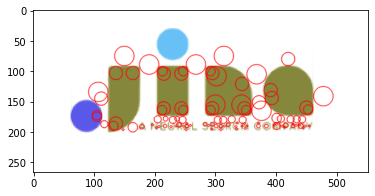

(<matplotlib.image.AxesImage at 0x7fefdc40c9a0>, None)

In [190]:

# Initiate BRIEF extractor
brief = cv.xfeatures2d.BriefDescriptorExtractor_create()
star = cv.xfeatures2d.StarDetector_create()
kp = star.detect(query,None)
kp, des = brief.compute(query, kp)

img2 = cv.drawKeypoints(query,kp,None,(255,0,0),4)
plt.imshow(img2),plt.show()

Let us add the jina images into our embeddings without modifying the codebook

In [252]:
image_descriptors_ = []

for k,image in enumerate(images):
    image_descriptors_new =  descriptors_image(image, kmeans, min_dist_param)
    image_descriptors_.append(image_descriptors_new)
    #print(k)
    
X_embeddings_new = np.array( image_descriptors_)

In [253]:
query_embedding = descriptors_image(query, kmeans, min_dist_param)
#query_embedding[query_embedding >=2]  += query_embedding[query_embedding >=2] 
query_embedding[query_embedding >=2]  = 10*query_embedding[query_embedding >=2] 


distances_to_query = np.linalg.norm(query_embedding - X_embeddings_new,axis=1)

closest_indices = distances_to_query.argsort()
closest_distances = [distances_to_query[k] for k in closest_indices] 
len(closest_indices)

45

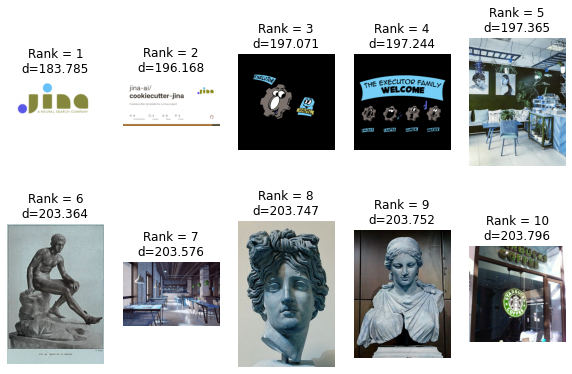

In [254]:
plt.figure(figsize=(10,10))
columns = 5
top_k = 10

closest_k_inds = closest_indices[0:top_k]
closest_k_dists = closest_distances[0:top_k]

for i, (ind, dist) in enumerate(zip(closest_k_inds, closest_k_dists)):
    fig = plt.subplot( int(len(closest_k_dists) / columns + 1), columns, i + 1)
    plt.axis('off')
    fig.set_title(f"Rank = {i+1}\nd={round(dist,3)}")
    plt.imshow(images[ind])